# L3: Text clustering and topic modelling

Text clustering groups documents in such a way that documents within a group are more &lsquo;similar&rsquo; to other documents in the cluster than to documents not in the cluster. The exact definition of what &lsquo;similar&rsquo; means in this context varies across applications and clustering algorithms.

In this lab you will experiment with both hard and soft clustering techniques. More specifically, in the first part you will be using the $k$-means algorithm, and in the second part you will be using a topic model based on the Latent Dirichlet Allocation (LDA).

## Hard clustering data set

The raw data for the hard clustering part of this lab is a collection of product reviews. We have preprocessed the data by tokenization and lowercasing.

In [1]:
import pandas as pd
import bz2

with bz2.open("reviews.json.bz2") as source:
    df = pd.read_json(source)

When you inspect the data frame, you can see that there are three labelled columns: `category` (the product category), `sentiment` (whether the product review was classified as &lsquo;positive&rsquo; or &lsquo;negative&rsquo; towards the product), and `text` (the space-separated text of the review).

In [2]:
df.head()

,category,sentiment,text
0,music,neg,i bought this album because i loved the title ...
1,music,neg,i was misled and thought i was buying the enti...
2,books,neg,"i have introduced many of my ell , high school..."
3,books,pos,anything you purchase in the left behind serie...
4,dvd,pos,"i loved these movies , and i cant wiat for the..."


In [3]:
set(df.category)

{'books', 'camera', 'dvd', 'health', 'music', 'software'}

## Problem 1: K-means clustering

Your first task is to cluster the product review data using a tf–idf vectorizer and a $k$-means clusterer.

Start by doing the vectorization. In connection with vectorization, you should also filter out standard English stop words. While you could use [spaCy](https://spacy.io/) for this task, here it suffices to use the word list implemented in [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [4]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])
def preprocess(text):
    doc = nlp(text)
    out = [token.lemma_ for token in doc if not token.is_stop and token.lemma_.isalpha()]
    return out

In [5]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=preprocess)
reviews = vectorizer.fit_transform(df["text"])

Test your vectorization by running the following code cell:

In [6]:
reviews.shape

(11914, 34940)

If you used the English stop word list from scikit-learn, then the resulting vocabulary should have 46,619 entries.

Next, cluster the vectorized data. Before doing so, you should read the documentation of the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class, which is scikit-learn&rsquo;s implementation of the $k$-means algorithm. As you can see, this class has several parameters that you can tweak. For now, the only parameter that you will have to set is the number of clusters. We recommend that you choose $k=3$.

**Tip:** Training $k$-means models will take some time. To speed things up, you can use the `n_init` parameter to control the number of times that the clustering is re-computed with different initial values. The default value for this parameter is 10; here and in the rest of this lab, you may want to set this to a lower value.

In [7]:
from sklearn.cluster import KMeans
k = 3
model_kmeans = KMeans(n_clusters=k, n_init=5, random_state=12345).fit(reviews)

To sanity-check your clustering, create a bar plot with the number of documents per cluster.

In [8]:
import matplotlib.pyplot as plt
# get cluster sizes
x, y = np.unique(model_kmeans.labels_, return_counts=True)

plt.bar(x, y, color="blue")
plt.xticks(x, x)    # to just have those values on x axis
plt.xlabel("Clusters")
plt.ylabel("Counts")
plt.title("Cluster Sizes")

plt.show()

<Figure size 640x480 with 1 Axes>

Note that sizes may vary considerable between clusters and among different random seeds.

## Problem 2: Summarize clusters

Once you have a clustering, you can try to see whether it is meaningful. One useful technique in that context is to generate a **summary** for each cluster by extracting the $n$ highest-weighted terms from the centroid of each cluster. Your next task is to implement this approach.

**Hint:** You will need to construct an &lsquo;inverted vocabulary&rsquo; that allows you to map from the index of a term back to the original term.

### n highest-weighted terms of centroids

In [9]:
def summarizeClusters(model_kmeans, trainVectorizer, n=10):
    # find the highest n tfidf values for each cluster
    summaryIndexes = [centroid.argsort()[-n:][::-1] for centroid in model_kmeans.cluster_centers_]
    # get the words from vectorizer
    summary = [[trainVectorizer.get_feature_names()[i] for i in summ] for summ in summaryIndexes]
    # transform it to dataframe and return
    return(pd.DataFrame({c: summary[c] for c in range(model_kmeans.n_clusters)}))

In [10]:
summarizeClusters(model_kmeans, vectorizer, 10)

,0,1,2
0,book,movie,camera
1,read,like,picture
2,write,product,lens
3,author,work,battery
4,story,great,canon
5,like,buy,take
6,find,good,buy
7,character,time,digital
8,page,album,use
9,time,well,flash


### Re-cluster with k=6

In [11]:
model_kmeans_k6 = KMeans(n_clusters=6, n_init=5, random_state=12345).fit(reviews)

In [12]:
summary_k6 = summarizeClusters(model_kmeans=model_kmeans_k6, trainVectorizer=vectorizer, n=10)
summary_k6

,0,1,2,3,4,5
0,camera,work,movie,book,album,program
1,picture,product,film,read,song,software
2,lens,buy,watch,write,cd,product
3,battery,great,see,author,music,version
4,take,like,like,story,listen,computer
5,canon,good,character,like,like,use
6,buy,time,story,find,sound,work
7,use,use,scene,page,band,install
8,digital,well,great,character,track,easy
9,flash,hair,good,time,great,upgrade


Once you have computed the cluster summaries, discuss their quality. Is it clear what the reviews in a given cluster are about? Which clusters are clearest? Which are less clear? Do the cluster summaries contain any unexpected terms? What happens if you re-cluster with, say, $k=6$?

*TODO: Insert your analysis of the clusters here*

## Problem 3: Tune the k-means algorithm

A major limitation of the $k$-means algorithm is that one has to manually set the value for $k$, the number of clusters. One heuristic that can help you with this is the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). Your next task is to implement this method to see whether it allows you to find a better value for $k$.

To follow the elbow method, you should plot different values of $k$ against the **inertia** (sums of squared distances between documents and closest centroids) of the fitted $k$-means model, and pick the $k$ at the &lsquo;elbow point&rsquo; of the resulting graph. Test cluster sizes between 1 and 9.

**Note that this will take a while.**

In [13]:
def elbow_method(trainData, kValues=[1,2,3]):
    intertiaScores = [KMeans(n_clusters=k, 
                             n_init=5, 
                             random_state=12345).
                      fit(trainData).inertia_ for k in kValues]
    return(pd.DataFrame({"k": kValues, "intertia": intertiaScores}))

In [14]:
intertias = elbow_method(reviews, list(range(1,10)))

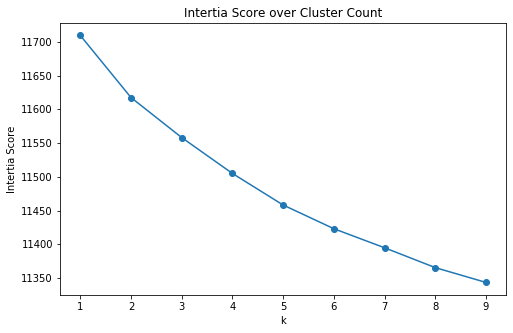

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(intertias.k, intertias.intertia, "o-")
ax.set(xlabel='k', ylabel='Intertia Score',
       title='Intertia Score over Cluster Count')

plt.show()

Once you have the diagram, can you see a pronounced &lsquo;elbow point&rsquo;? Discuss your findings in a short text.

*TODO: Insert your discussion of the elbow method here*

## Problem 4: Compare clusterings using the Rand index

In some scenarios, you may have gold-standard class labels available for at least a subset of your documents. In these cases you can compute the **Rand index** of a clustering, and use this measure to compare the quality of different clusterings.

To compute the Rand index, we view a clustering as a binary classifier on pairs of documents. The classifier predicts &lsquo;positive&rsquo; if and only if the two documents belong to the same cluster. The (non-normalized) Rand index of the clustering is the accuracy of this classifier relative to a reference in which a document pair belongs to the &lsquo;positive&rsquo; class if and only if the two documents in the pair have the same gold-standard class label.

Compare a clustering with $k=3$ clusters to a second clustering with $k=6$ clusters. As your evaluation data, use the first 500 documents from the original data set along with their gold-standard categories (from the `category` column). What do you observe? How do you interpret your observations? What arguments can you find against the Rand index as a measure for comparing clusterings?

### randIndex function and Solution

In [16]:
from itertools import combinations
def randIndex(golden, pred):
    '''this function first transforms vectors to pairs for each and compare those pairs
    and finds booleans for the pairs in golden and pred inputs. After that compares
    those booleans in order to classify pairs and calculate accuracy of it.'''
    golden, pred = np.array(golden), np.array(pred)
    n = len(golden)
    compare = lambda x: x[0]==x[1]
    pairClassifier = [compare(golden[list(pair)]) == compare(pred[list(pair)]) 
                      for pair in combinations(range(n),2)]
    return(np.sum(pairClassifier) / len(pairClassifier))

In [17]:
n = 500
pred_k3 = model_kmeans.labels_[:n]
pred_k6 = model_kmeans_k6.labels_[:n]
golden = np.array(df["category"][:n])

In [18]:
print("randIndex Accuracy k3:\t", randIndex(golden, pred_k3))
print("randIndex Accuracy k6:\t", randIndex(golden, pred_k6))

randIndex Accuracy k3:	 0.46926653306613225
randIndex Accuracy k6:	 0.7719038076152305


*TODO: Insert your discussion of your results here*

### Quicklook to randIndex function

In [19]:
golden = np.array([1,1,2])
pred = np.array([3,3,1])
n = len(golden)

In [20]:
compare = lambda x: x[0]==x[1]

In [21]:
cmb = combinations(range(n),2)

In [22]:
# get all pairs of golden and preds
[(golden[list(pair)], pred[list(pair)]) for pair in combinations(range(n),2)]

[(array([1, 1]), array([3, 3])),
 (array([1, 2]), array([3, 1])),
 (array([1, 2]), array([3, 1]))]

In [23]:
# compare pairs to get booleans
[(compare(golden[list(pair)]), compare(pred[list(pair)])) for pair in combinations(range(n),2)]

[(True, True), (False, False), (False, False)]

In [24]:
# compare resulting booleans too and we can calculate accuracy for classifier
[compare(golden[list(pair)]) == compare(pred[list(pair)]) for pair in  combinations(range(n),2)]

[True, True, True]

## Topic modelling data set

The data set for the topic modelling part of this lab is the collection of all [State of the Union](https://en.wikipedia.org/wiki/State_of_the_Union) addresses from the years 1975–2000. These speeches come as a single text file with one sentence per line. The following code cell prints the first 5 lines from the data file:

In [25]:
with open("sotu_1975_2000.txt") as source:
    for i, line in enumerate(source):
        print(line.rstrip())
        if i >= 5:
            break

mr speaker mr vice president members of the 94th congress and distinguished guests
twenty six years ago a freshman congressman a young fellow with lots of idealism who was out to change the world stood before sam rayburn in the well of the house and solemnly swore to the same oath that all of you took yesterday an unforgettable experience and i congratulate you all
two days later that same freshman stood at the back of this great chamber over there someplace as president truman all charged up by his single handed election victory reported as the constitution requires on the state of the union
when the bipartisan applause stopped president truman said i am happy to report to this 81st congress that the state of the union is good our nation is better able than ever before to meet the needs of the american people and to give them their fair chance in the pursuit of happiness it is foremost among the nations of the world in the search for peace
today that freshman member from michigan stan

## Problem 5: Train a topic model

Your first task on the topic modelling data is to train an LDA model. For this task you will be using [spaCy](https://spacy.io/) and the [gensim](https://radimrehurek.com/gensim/) topic modelling library.

Start by preprocessing the data using spaCy. Given that the data set for this problem is rather small, you do not have to exclude any components from the standard pipeline. Filter out stop words, non-alphabetic tokens, and tokens less than 3 characters in length. Store the documents as a nested list where the first level of nesting corresponds to the sentences and the second level corresponds to the tokens in each sentence.

In [26]:
# TODO: Replace the following lines with your own code for preprocessing the documents
with open("sotu_1975_2000.txt") as source:
    documents = [line.split() for line in source]

### Pre-process function

In [27]:
def preprocess2(text):
    doc = nlp(text)
    out = [token.text for token in doc if not token.is_stop and token.lemma_.isalpha() and len(token.text)>=3]
    return out

Test your preprocessing by running the following cell:

In [28]:
" ".join(documents[42])

'first we must reduce oil imports by 1 million barrels per day by the end of this year and by 2 million barrels per day by the end of 1977'

In [29]:
" ".join(preprocess2(" ".join(documents[42])))

'reduce oil imports million barrels day end year million barrels day end'

You should get the following output:

Once you have the list of documents, skim the section [Pre-process and vectorize the documents](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents) of the gensim documentation to learn how to create the dictionary and the vectorized corpus representation required by gensim. (Note that you cannot use the standard scikit-learn pipeline in this case.) Then, write code to train an [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html) for $k=10$ topics, and using default values for all other parameters.

### Create Dictionary and Corpus

In [30]:
docs = [" ".join(preprocess2(" ".join(doc))) for doc in documents]

In [31]:
docs[42]

'reduce oil imports million barrels day end year million barrels day end'

#### 1. Tokenize Document

In [32]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

#### 2. Lemmatize the doc

In [33]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

#### 3. Compute Bigrams

In [34]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

#### 4. Create Bag-of-words

In [35]:
from gensim.corpora import Dictionary
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [36]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 735
Number of documents: 2898


### Train LDA Model

In [37]:
from gensim.models import LdaModel
# Set training parameters.
num_topics = 10

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(corpus,
                 id2word = id2word,
                 num_topics=num_topics)

Once you have a trained model, run the following cell to print the topics:

In [38]:
model.print_topics()

[(0,
  '0.022*"year" + 0.019*"american" + 0.018*"let" + 0.017*"program" + 0.016*"help" + 0.013*"america" + 0.013*"state" + 0.011*"drug" + 0.010*"child" + 0.010*"congress"'),
 (1,
  '0.020*"new" + 0.014*"year" + 0.014*"way" + 0.013*"energy" + 0.012*"national" + 0.010*"program" + 0.009*"budget" + 0.009*"nation" + 0.008*"security" + 0.008*"congress"'),
 (2,
  '0.031*"year" + 0.019*"america" + 0.019*"american" + 0.018*"family" + 0.016*"child" + 0.013*"century" + 0.013*"challenge" + 0.012*"house" + 0.012*"new" + 0.010*"tonight"'),
 (3,
  '0.018*"nation" + 0.017*"year" + 0.013*"god" + 0.013*"technology" + 0.013*"god_bless" + 0.013*"bless" + 0.012*"america" + 0.012*"long" + 0.012*"community" + 0.011*"thank"'),
 (4,
  '0.018*"world" + 0.018*"new" + 0.016*"america" + 0.015*"american" + 0.013*"year" + 0.012*"family" + 0.012*"child" + 0.011*"rate" + 0.010*"people" + 0.010*"tax"'),
 (5,
  '0.023*"child" + 0.019*"government" + 0.015*"school" + 0.013*"parent" + 0.012*"economy" + 0.012*"year" + 0.012

In [39]:
top_topics = model.top_topics(corpus)
firstN = 10
pd.DataFrame({i:[topic for topic in top_topics[i][0][:firstN]] for i in range(num_topics)})

,0,1,2,3,4,5,6,7,8,9
0,"(0.022986205, child)","(0.021737935, year)","(0.017951543, world)","(0.028418843, people)","(0.020201735, new)","(0.028674955, child)","(0.043217164, year)","(0.017441614, crime)","(0.030746069, year)","(0.01846164, nation)"
1,"(0.019004058, government)","(0.019293865, american)","(0.017610706, new)","(0.02229704, america)","(0.014308378, year)","(0.023755975, work)","(0.020276232, american)","(0.015923787, citizen)","(0.01867301, america)","(0.016814448, year)"
2,"(0.015391758, school)","(0.018484678, let)","(0.015674274, america)","(0.020816924, american)","(0.013598291, way)","(0.018824788, year)","(0.016512575, cut)","(0.014414362, president)","(0.018559106, american)","(0.013326971, god)"
3,"(0.013437903, parent)","(0.016888404, program)","(0.015249688, american)","(0.017689362, new)","(0.012649124, energy)","(0.017812943, american)","(0.01624971, congress)","(0.01333797, new)","(0.017505182, family)","(0.013223111, technology)"
4,"(0.0122441435, economy)","(0.016360195, help)","(0.0131134, year)","(0.015415188, security)","(0.012026628, national)","(0.01730547, america)","(0.015225813, tax)","(0.013017159, member)","(0.015589943, child)","(0.012517443, god_bless)"
5,"(0.011924842, year)","(0.012709367, america)","(0.011819086, family)","(0.014108517, work)","(0.009759065, program)","(0.0148722585, people)","(0.013742266, people)","(0.012979003, government)","(0.013160675, century)","(0.012514145, bless)"
6,"(0.011527876, state)","(0.012657817, state)","(0.011560527, child)","(0.013751344, know)","(0.009302522, budget)","(0.012982504, world)","(0.011908766, work)","(0.012453728, know)","(0.013011877, challenge)","(0.012221645, america)"
7,"(0.0114133535, new)","(0.010747124, drug)","(0.010501814, rate)","(0.013734661, year)","(0.00870952, nation)","(0.011415696, nation)","(0.010595616, percent)","(0.012146404, right)","(0.012064069, house)","(0.012132996, long)"
8,"(0.010327195, world)","(0.010465229, child)","(0.01049841, people)","(0.011503629, country)","(0.007819439, security)","(0.011202975, new)","(0.010421523, new)","(0.011389531, century)","(0.011821442, new)","(0.011694807, community)"
9,"(0.010178064, private)","(0.010324701, congress)","(0.0104779005, tax)","(0.0105232345, government)","(0.007769439, congress)","(0.010696806, time)","(0.009306581, million)","(0.010999501, congress)","(0.010446649, tonight)","(0.011096456, thank)"


Inspect the topics. Do they make sense? Can you &lsquo;label&rsquo; each topic with a short description of what it is about? Do the topics contain any unexpected terms? Summarize your discussion in a short text.

*TODO: Insert your discussion of the topics here*

## Problem 6: Monitoring a topic model for convergence

When learning an LDA model, it is important to make sure that the training algorithm has converged to a stable posterior distribution. One way to do so is to plot, after each training epochs(or &lsquo;pass&rsquo;, in gensim parlance) the log likelihood of the training data under the posterior. Your last task in this lab is to create such a plot and, based on this, to suggest an appropriate number of epochs.

To collect information about the posterior likelihood after each pass, we need to enable the logging facilities of gensim. Once this is done, gensim will add various diagnostics to a log file `gensim.log`.

In [40]:
import logging

logging.basicConfig(filename="Gensim.log", filemode='w', format="%(asctime)s:%(levelname)s:%(message)s", level=logging.INFO)

The following function will parse the generated logfile and return the list of log likelihoods.

In [41]:
import re

def parse_logfile():
    matcher = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
    likelihoods = []
    with open("Gensim.log") as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    return likelihoods

Your task now is to re-train your LDA model for 50&nbsp;passes, retrieve the list of log likelihoods, and create a plot from this data.

In [42]:
nPasses = 50
model2 = LdaModel(corpus,
                 id2word = id2word,
                 num_topics=num_topics, passes=nPasses)

In [44]:
logs = parse_logfile()

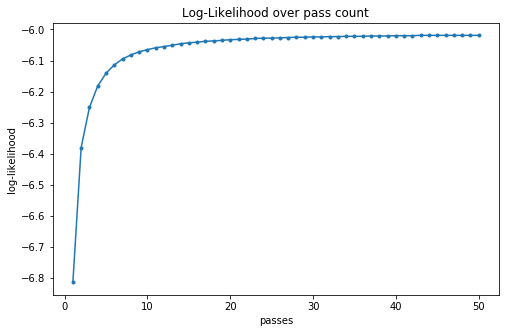

In [47]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(range(1,nPasses+1), logs[-nPasses:], ".-")
ax.set(xlabel='passes', ylabel='log-likelihood',
       title='Log-Likelihood over pass count')
plt.show()

How do you interpret your plot? What would be a reasonable choice for the number of passes? Retrain your LDA model with that number and re-inspect the topics it finds. Do you consider the new topics to be &lsquo;better&rsquo; than the ones that you got from the 1-pass model in Problem&nbsp;5?

*TODO: Insert your discussion of these questions here*

In [48]:
nPasses = 15
model_best = LdaModel(corpus,
                 id2word = id2word,
                 num_topics=num_topics, passes=nPasses)

top_topics = model_best.top_topics(corpus)
firstN = 10
pd.DataFrame({i:[topic for topic in top_topics[i][0][:firstN]] for i in range(num_topics)})

,0,1,2,3,4,5,6,7,8,9
0,"(0.04332917, year)","(0.04133253, america)","(0.030337075, policy)","(0.035071112, family)","(0.057414502, people)","(0.053058386, child)","(0.0496235, year)","(0.037448566, security)","(0.03884862, congress)","(0.03227791, year)"
1,"(0.028410226, tax)","(0.04054646, world)","(0.020741481, economic)","(0.03188149, care)","(0.045526322, know)","(0.03312454, community)","(0.02094156, new)","(0.029768432, force)","(0.025224857, crime)","(0.030579813, state)"
2,"(0.025447141, government)","(0.03222211, american)","(0.02003261, administration)","(0.030498348, child)","(0.03826604, american)","(0.031407602, school)","(0.020579264, time)","(0.026962778, soviet)","(0.025199702, law)","(0.028893825, school)"
3,"(0.025337014, program)","(0.026834304, nation)","(0.01880179, nation)","(0.029398095, health)","(0.025770374, government)","(0.026826354, social)","(0.020504473, economy)","(0.02454924, defense)","(0.023017094, reform)","(0.020569244, middle)"
4,"(0.0236493, federal)","(0.026810363, people)","(0.01607399, energy)","(0.028665626, work)","(0.022931648, way)","(0.02406274, america)","(0.018746236, ago)","(0.021040374, military)","(0.021799173, president)","(0.018683344, united)"
5,"(0.023196673, cut)","(0.01948656, freedom)","(0.015114017, trade)","(0.023262642, million)","(0.022255415, work)","(0.021453286, security)","(0.01712182, year_ago)","(0.020218886, woman)","(0.017433075, bill)","(0.018411612, education)"
6,"(0.021115296, rate)","(0.019205242, peace)","(0.01498804, system)","(0.020868752, american)","(0.020804903, want)","(0.019724863, social_security)","(0.016806737, world)","(0.01797005, nation)","(0.016875312, budget)","(0.01725461, united_state)"
7,"(0.020994825, budget)","(0.018840915, state)","(0.014278904, program)","(0.019462354, job)","(0.019020177, like)","(0.018713584, parent)","(0.016216291, day)","(0.017713789, war)","(0.016734218, right)","(0.016605275, congress)"
8,"(0.018961474, new)","(0.017317673, union)","(0.0132283475, development)","(0.019280868, year)","(0.018486712, tonight)","(0.015490725, year)","(0.0146495765, american)","(0.015408504, national)","(0.016148988, year)","(0.016113525, right)"
9,"(0.018958565, billion)","(0.012559502, new)","(0.012903106, new)","(0.018890051, people)","(0.018101713, america)","(0.015120261, century)","(0.014513296, america)","(0.014331441, ally)","(0.0142753245, drug)","(0.01604705, new)"


<div class="alert alert-info">
    Please read the section ‘General information’ on the ‘Labs’ page of the course website before submitting this notebook!
</div>